# Example usage with pennylane
This notebook shows some examples of generating Quantum Convolutional Neural Networks (QCNNs)

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

In [2]:
# Core
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    plot_graph,
)
# Pennylane helpers
from dynamic_qcnn.pennylane import get_param_info_pennylane, execute_circuit_pennylane 

In [3]:
# Specify QNode
dev = qml.device("default.qubit", wires=[i+1 for i in range(8)])

@qml.qnode(dev)
def circuit(motif, params):
    response_wire = motif.head.Q_avail # This is the 'last' available qubit
    execute_circuit_pennylane(motif, params) # This executes the compute graph in order
    return qml.expval(qml.PauliZ(response_wire))

# Specify drawer
qml.drawer.use_style("black_white")

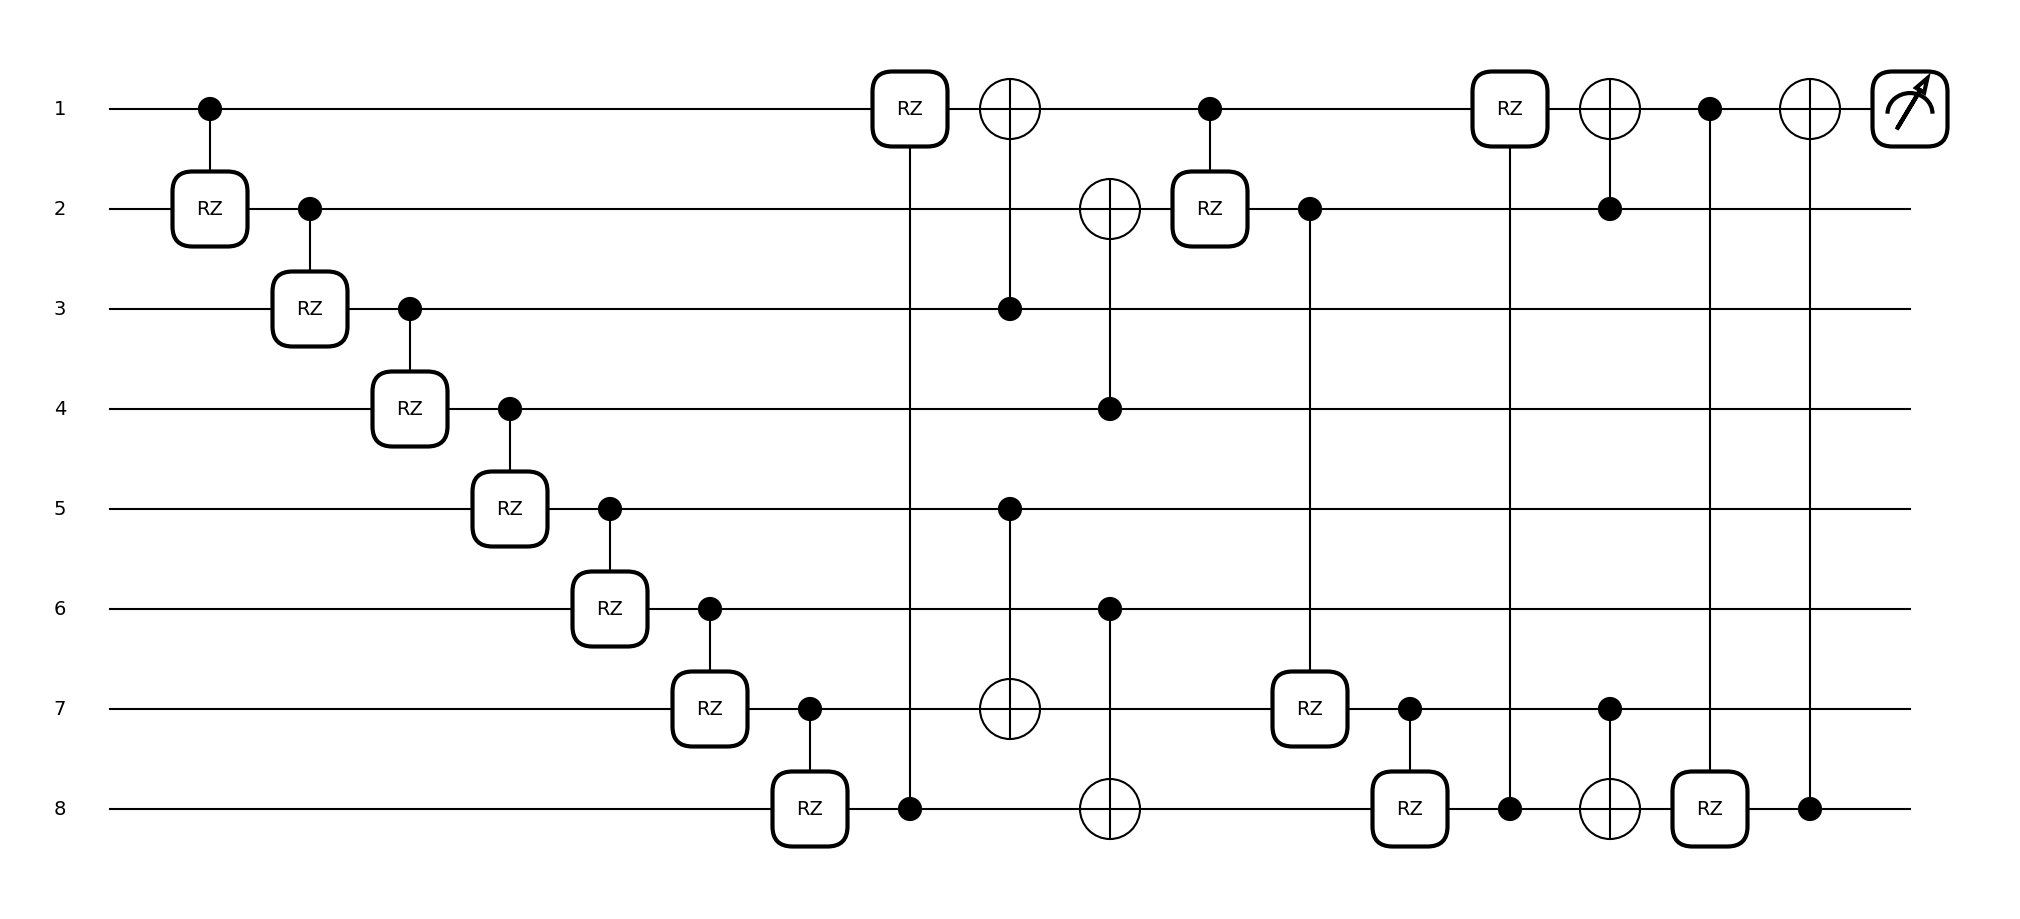

In [4]:
# Build circuit
motif  = Qfree(8) + (Qconv(1) + Qpool(filter="inside"))*3

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(motif)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(motif, params)

In [17]:
print(f"Number of coefficients:{total_coef_count}")
print(f"Coefficients per layer:\n{coef_indices}")

Number of coefficients:4
Coefficients per layer:
{0: range(0, 1), 1: None, 2: range(1, 2), 3: None, 4: range(2, 3), 5: None, 6: range(3, 4), 7: None}


In [22]:
# Execute the circuit
print(circuit(motif, params))

WireError: Did not find some of the wires (8, 9) on device with wires (1, 2, 3, 4, 5, 6, 7, 8).

## Reverse binary tree

In [ ]:
### Reverse binary tree
N = 8
# level 1
m1_1 = Qconv(stride=1)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
# m3_1 + Qfree([1,3,5]) + Qconv(5)+m3_1)*4
SVGCircuit(circuit)

### More arbitrary examples to show what is possible

In [ ]:
m1 = Qfree(6)+Qconv()
m2 = m1 + Qpool(1, "000101")
m3 = m2 + Qfree(8) + Qconv(1) + Qpool(2,"11111110")
m4 = m3 + Qfree(4) + (Qconv(1)+Qpool(0,"even"))*2
m5 = m4 + m4
circuit, symbols = convert_graph_to_circuit_cirq(m5)
SVGCircuit(circuit)

In [ ]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(
    (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4
)
SVGCircuit(circuit)

## Multiscale Entanglement Renormalization Ansatz (MERA)

In [ ]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
SVGCircuit(circuit)

## Random QCNNs

In [ ]:
# More structure
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ]# + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

In [ ]:
# loose
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [Qpool(s_p, filter=i_filter) for i_filter in ("right", "left", "even", "odd", "inside", "outside") for s_p in range(n)]
    c = [Qconv(stride=s_c, step=s_t, offset=s_o) for s_c in range(1, n, 1) for s_t in range(1, 2, 1) for s_o in range(n)]+ [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

## Specifying unitaries

In [ ]:
# Pooling circuit
def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[1]).on(q0)
    circuit += cirq.ry(symbols[2]).on(q1)
    circuit += cirq.CNOT(q0, q1)
    circuit += cirq.ry(symbols[3]).on(q1)
    return circuit


# Convolution circuit
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[1]).on(q0)
    circuit += cirq.ry(symbols[2]).on(q1)
    circuit += cirq.CNOT(q0, q1)
    circuit += cirq.ry(symbols[3]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[4]).on(q0)
    return circuit

In [ ]:
M = Qfree(8) + (Qconv(1, convolution_mapping=(U, 5)) + Qpool(filter="left", pooling_mapping=(V, 4)))* 3
circuit, symbols = convert_graph_to_circuit_cirq(M)

In [ ]:
SVGCircuit(circuit)

### Cycle through unitary ansatzes

In [ ]:
# Pooling circuit
def V_1(bits, symbols=None): # 1
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rx(symbols[0]).on(q1).controlled_by(q0)

    return circuit
def V_2(bits, symbols=None): # 0
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.CNOT(q0, q1)
    return circuit


# Convolution circuit
def U_1(bits, symbols=None): # 1
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    return circuit

def U_2(bits, symbols=None): # 1
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.ry(symbols[0]).on(q1).controlled_by(q0)
    return circuit
function_mappings = {"convolution":[(U_1,1), (U_2,1)], "pooling":[(V_1,1),(V_2,0)]}



In [ ]:
qcnn = Qcnn(16, function_mappings=function_mappings)

qcnn = qcnn + (Qconv(2)+Qpool(1,"outside"))*4 
circuit, symbols = convert_graph_to_circuit_cirq(qcnn)
SVGCircuit(circuit)